# House price prediction

### Problem Statement:
To develop a machine learning model to predict the price of house for an real estate company

In [174]:
## Importing modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import os
import tarfile
import urllib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR
import warnings
warnings.filterwarnings('ignore')

In [100]:
## Downloading source dataset
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

## Function to download dataset
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [101]:
## Calling the download function
fetch_housing_data()

In [102]:
## Reading the data as dataframe
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

### Exploring the data

In [103]:
housing.shape

(20640, 10)

In [104]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [105]:
# Checking for columns with null values

housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [106]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [107]:
# Checking ocean proximity values
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

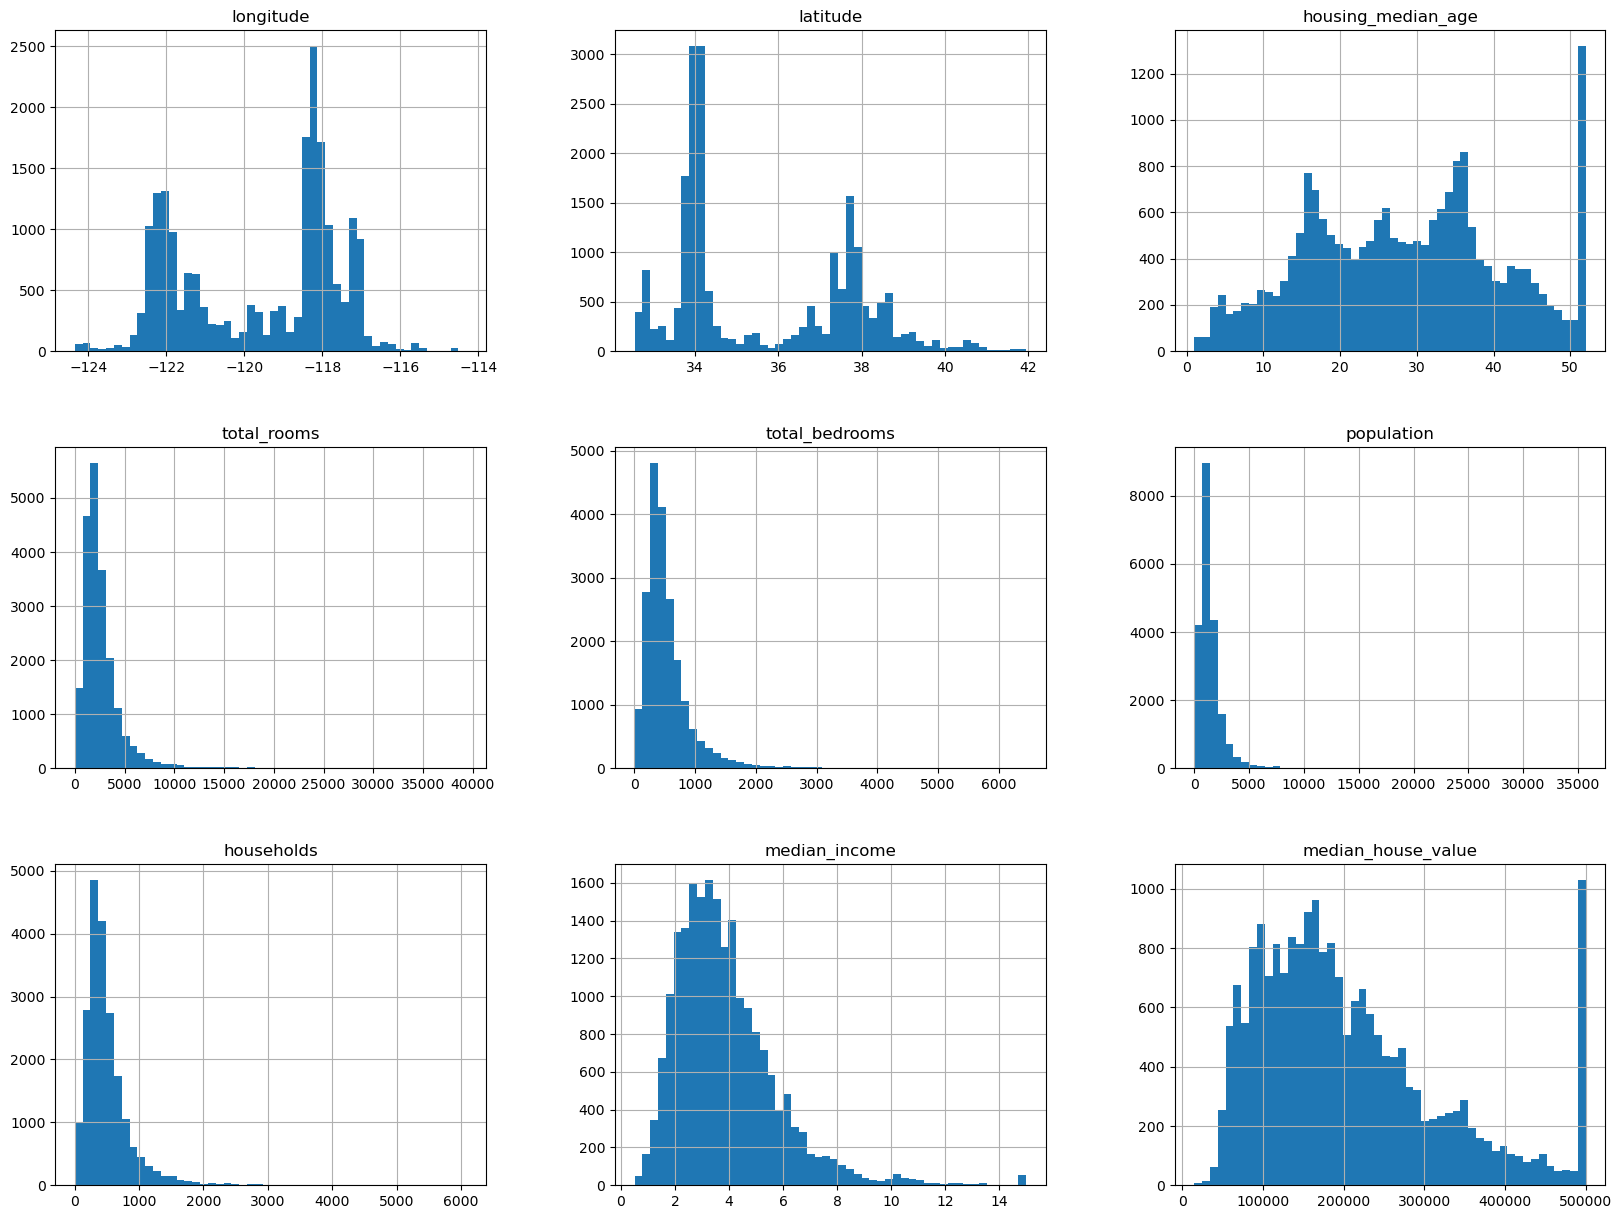

In [108]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [109]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(16512, 10)
(4128, 10)


In [110]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

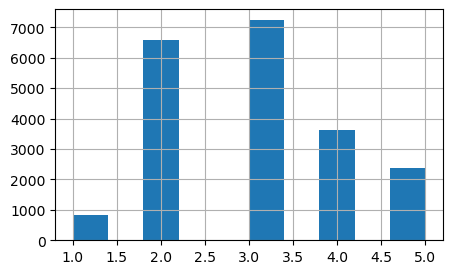

In [111]:
housing["income_cat"].hist(figsize=(5,3))
plt.show()

In [112]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [113]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [114]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [115]:
housing = strat_train_set.copy()

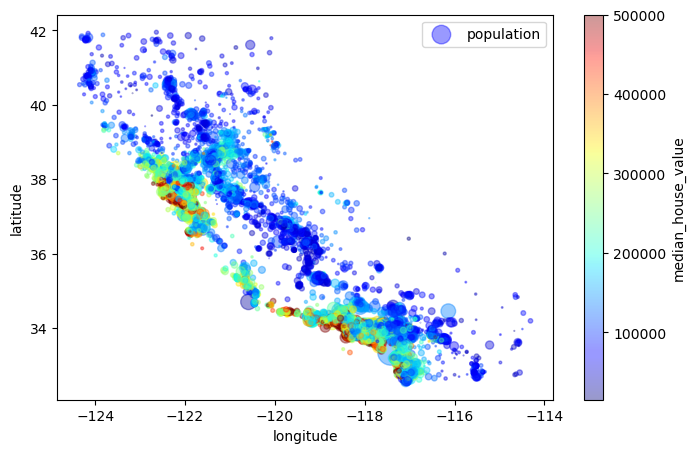

In [116]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(8,5),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.show()

### Correlation check

In [117]:
corr_matrix = housing.corr()

In [118]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

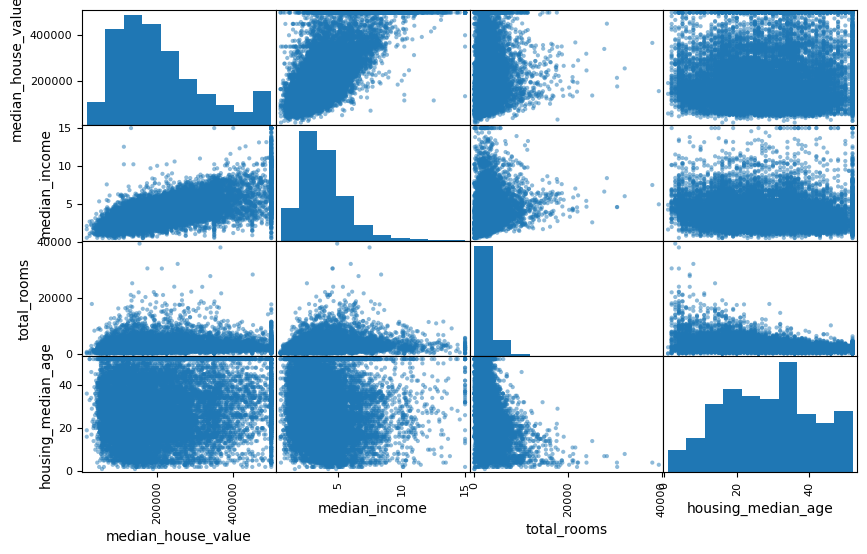

In [119]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(10, 6))
plt.show()

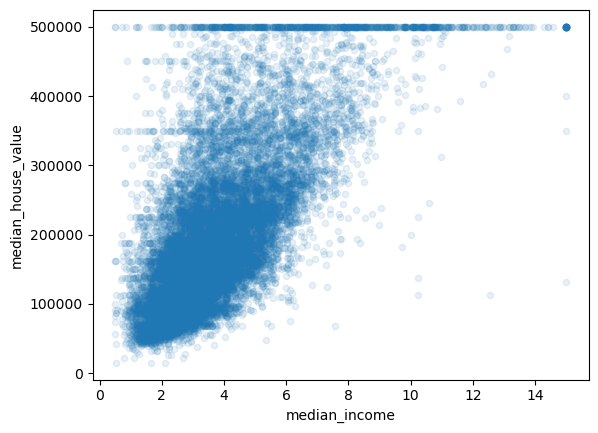

In [120]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.show()

In [121]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [122]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [123]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [124]:
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [125]:
imputer = SimpleImputer(strategy="median")

In [126]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [127]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [128]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [129]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [130]:
X = imputer.transform(housing_num)

In [131]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [132]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [133]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [134]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [135]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [136]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [137]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom transform

In [138]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

In [139]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [140]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### Training and Evaluating

In [141]:
## Linear regression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [142]:
## Evaluating
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [143]:
## Decision Tree Regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [144]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [145]:
## RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(tree_mse)
forest_rmse

0.0

### Grid search

In [146]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [147]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [148]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [149]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

62634.39358813535 {'max_features': 2, 'n_estimators': 3}
55837.48643616256 {'max_features': 2, 'n_estimators': 10}
52875.52065131316 {'max_features': 2, 'n_estimators': 30}
59436.92573214909 {'max_features': 4, 'n_estimators': 3}
52816.64233479463 {'max_features': 4, 'n_estimators': 10}
50677.16189273273 {'max_features': 4, 'n_estimators': 30}
59550.70369427891 {'max_features': 6, 'n_estimators': 3}
51982.12726433354 {'max_features': 6, 'n_estimators': 10}
49984.896799684044 {'max_features': 6, 'n_estimators': 30}
58873.05779005398 {'max_features': 8, 'n_estimators': 3}
52545.99838907249 {'max_features': 8, 'n_estimators': 10}
50239.55047484813 {'max_features': 8, 'n_estimators': 30}
61725.680537801854 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54396.461781498365 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61039.52884257543 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53220.313140213635 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [150]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.41912133e-02, 6.96311674e-02, 4.27411842e-02, 1.73851322e-02,
       1.57741489e-02, 1.80958666e-02, 1.54500584e-02, 2.93982551e-01,
       6.72766734e-02, 1.12740551e-01, 9.51626010e-02, 1.51741820e-02,
       1.53157309e-01, 8.84937412e-05, 2.84711856e-03, 6.30174860e-03])

In [151]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.29398255139828605, 'median_income'),
 (0.15315730925818494, 'INLAND'),
 (0.11274055108749069, 'pop_per_hhold'),
 (0.09516260103557173, 'bedrooms_per_room'),
 (0.07419121334976143, 'longitude'),
 (0.06963116735661008, 'latitude'),
 (0.06727667336132225, 'rooms_per_hhold'),
 (0.04274118415602511, 'housing_median_age'),
 (0.01809586655257319, 'population'),
 (0.0173851321744622, 'total_rooms'),
 (0.015774148913082684, 'total_bedrooms'),
 (0.01545005842838802, 'households'),
 (0.01517418202462092, '<1H OCEAN'),
 (0.006301748604150505, 'NEAR OCEAN'),
 (0.002847118558249714, 'NEAR BAY'),
 (8.849374122049913e-05, 'ISLAND')]

In [152]:
## Final model with best estimator
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47930.48794902446

### Exercise

In [153]:
SVR = SVR(kernel="linear")

In [154]:
SVR.fit(housing_prepared, housing_labels)
housing_predictions = SVR.predict(housing_prepared)
SVR_mse = mean_squared_error(housing_labels, housing_predictions)
SVR_rmse = np.sqrt(SVR_mse)
SVR_rmse

111095.06635291968

In [155]:
## Gridsearch CV
SVR = SVR
param_grid = [
     {'kernel': ['linear'], 'C': [1.0, 3.0, 10., 30]},
     {'kernel': ['rbf'],    'C': [1.0, 3.0, 10., 30]},
     
  ]

grid_search = GridSearchCV(SVR, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=3, estimator=SVR(kernel='linear'),
             param_grid=[{'C': [1.0, 3.0, 10.0, 30], 'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30], 'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [156]:
grid_search.best_params_

{'C': 30, 'kernel': 'linear'}

In [157]:
SVR_grid_final = grid_search.best_estimator_

In [158]:
housing_predictions = SVR_grid_final.predict(housing_prepared)
SVR_grid_final_mse = mean_squared_error(housing_labels, housing_predictions)
SVR_grid_final_rmse = np.sqrt(SVR_grid_final_mse)
SVR_grid_final_rmse

74317.984805103

In [159]:
## RandomizedSearchCV
# SVR = SVR()
param_grid = [
    {'kernel': ['linear'], 'C': [1.0, 3.0, 10., 30]},
    {'kernel': ['rbf'],    'C': [1.0, 3.0, 10., 30]},
  ]
randomized_search = RandomizedSearchCV(SVR,param_grid, cv=3,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True)
randomized_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=3, estimator=SVR(kernel='linear'),
                   param_distributions=[{'C': [1.0, 3.0, 10.0, 30],
                                         'kernel': ['linear']},
                                        {'C': [1.0, 3.0, 10.0, 30],
                                         'kernel': ['rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [160]:
randomized_search.best_params_

{'kernel': 'linear', 'C': 30}

In [161]:
SVR_random_final = randomized_search.best_estimator_

In [162]:
housing_predictions = SVR_random_final.predict(housing_prepared)
SVR_random_final_mse = mean_squared_error(housing_labels, housing_predictions)
SVR_random_final_rmse = np.sqrt(SVR_random_final_mse)
SVR_random_final_rmse

74317.984805103

### Transformer 

In [163]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [164]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [165]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [166]:
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [167]:
k=4
top_k_feature_indices = indices_of_top_k(feature_importances, k)
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [168]:
housing_top_4_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

### Pipeline

In [177]:
from sklearn.svm import SVR
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('select_top_feature', TopFeatureSelector(feature_importances, k)),
    ('svm_model', SVR(**randomized_search.best_params_))
])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [178]:
## fitting data to pipeline
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(...
                ('select_top_feature',
                 TopFeatureSelector(feature_importances=array([7.41912133e-02, 6.96311674e-02, 4.27411842e-02, 1.73851322e-02,
       1.57741489e-02, 1.80958666e-02, 1.54500584e-02, 2.93982551e-01,
       6.72766734e-02, 1.12740551e-01, 9.51626010e-02, 1.51741820e-02,
       1.53157309e-01, 8.84937412e-05, 2.84711856e-03, 6.30174860e-03]),
                                    k=4)),
                ('svm_model', SVR(C=30, kernel='linear'))])

In [179]:
## Predict using pipeline
sample_data = housing.iloc[:5]
prepare_select_and_predict_pipeline.predict(sample_data)

array([ 92307.22410475, 284952.72469334, 116203.17376084, 149731.90262172,
       221171.26722291])